In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt

import matplotlib
cmap = matplotlib.colormaps['viridis']

import tensorflow as tf
print(tf. __version__)

2.10.0


## Load model

In [2]:
from SQ_NN import SQ_NN, SQ_NN_tf, Decoder_aug, sm_GP
from RMSA import RMSA
q_rs = (np.arange(80)+1)*0.2
def SQ_RMSA(parameters):
    return (RMSA(q_rs, 0.5, scl=parameters[1], gamma=parameters[2], eta=parameters[0]))[1]

## Define functions

In [3]:
def hardsphere(q,sigma=1):
    R = sigma/2
    P = (3*(np.sin(q*R)-q*R*np.cos(q*R))/(q*R)**3)**2
    return P

def scale(q,x,scale):
    qs = q*scale
    f_interp = interp.interp1d(qs, x, fill_value='extrapolate')
    x_interp = f_interp(q)
    return x_interp

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    dQ: The instrument resolution function
    '''
    
    Qmean = Q
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        w_gauss = (1/np.sqrt(2*np.pi*current_dQ**2))*np.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ_resoln = IQ_th*w_gauss
        
        IQ.append(np.trapz(IQ_resoln,Q_fine)/np.trapz(w_gauss,Q_fine))

    IQ_out = np.array(IQ)
    return IQ_out

def SQ_th(sq_func,fp):
    # structure factor
    return sq_func(fp[0:3])

def IQ_th(sq_func,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = SQ_th(sq_func,fp)

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)
    
    IQ_res_scale_interp = f_interp(q_rs)
    return IQ_res_scale_interp

## Load data

In [4]:
# Training set
parameters_zscore = 0
sq_min = np.exp(-5) # minimum of sq

if 1:
    X_file = './training_set/input_grid_all_GPR80.csv'
    Y_file = './training_set/target_grid_all.csv'
else:
    X_file = './training_set/input_random_all_GPR80.csv'
    Y_file = './training_set/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

eta_mean = np.mean(eta)
eta_std = np.std(eta)
kappa_mean = np.mean(kappa)
kappa_std = np.std(kappa)
A_mean = np.mean(A)
A_std = np.std(A)

# normalization
eta_z = (eta-eta_mean)/eta_std
kappa_z = (kappa-kappa_mean)/kappa_std
A_z = (A-A_mean)/A_std

if parameters_zscore:
    parameters_train = np.array([eta_z,kappa_z,A_z]).T
else:
    parameters_train = np.array([eta,kappa,A]).T

sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

# rescale
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

print('eta ~ N({:0.4f},{:0.4f})'.format(np.mean(eta),np.var(eta)))
print('kappa ~ N({:0.4f},{:0.4f})'.format(np.mean(kappa),np.var(kappa)))
print('A ~ N({:0.4f},{:0.4f})'.format(np.mean(A),np.var(A)))

eta ~ N(0.2325,0.0169)
kappa ~ N(0.2600,0.0208)
A ~ N(13.0000,52.0000)


### resolution

In [5]:
from scipy.io import loadmat
filename_EQSANS = './EQSANS.mat'
loaded_EQSANS = loadmat(filename_EQSANS)
q_EQSANS_0 = loaded_EQSANS['Q_real'][:,0]#.astype('float32')
qsig_EQSANS = loaded_EQSANS['qsig'][:,0]#.astype('float32')
data = loaded_EQSANS['data']#.astype('float32')
qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)*3
delta_I_EQSANS = data[:,2]
delta_I_EQSANS[delta_I_EQSANS==0] = 0.01

## Select data and produce I(Q)

In [6]:
print('\neta in')
print(np.unique(eta))
print('\nkappa in')
print(np.unique(kappa))
print('\nA in')
print(np.unique(A))


eta in
[0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15  0.165 0.18
 0.195 0.21  0.225 0.24  0.255 0.27  0.285 0.3   0.315 0.33  0.345 0.36
 0.375 0.39  0.405 0.42  0.435 0.45 ]

kappa in
[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5 ]

A in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25.]


In [7]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_eta = np.abs(eta-parameters[0])<tol
    id_kappa = np.abs(kappa-parameters[1])<tol
    id_A = np.abs(A-parameters[2])<tol
    return np.where(id_eta*id_kappa*id_A)[0]

In [8]:
parameters = np.array([0.225, 0.3, 6])
fp_GT = np.r_[parameters,np.array([1,1,0.01])]

SQ_exp_GT = sq_rs[id_params(parameters),:][0]

# sq_NN = SQ_NN(parameters)
# sq_NN_GP = SQ_NN(parameters,GP=True)
# sq_RMSA = SQ_RMSA(parameters)[1]

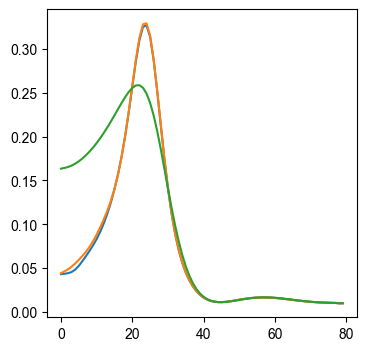

In [9]:
def IQ_exp(sq_GT,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = sq_GT

    # I(Q)
    IQ = S*P*fp[4]+fp[5]

    # resolution
    Q = q_EQSANS
    dQ = qsig_EQSANS
    Q_fine = np.linspace(0.2,16,100)

    f_interp = interp.interp1d(q,IQ)
    IQ_Qfine = f_interp(Q_fine)
    IQ_res = IQ_resoln(Q, Q_fine, IQ_Qfine, dQ)

    IQ_res_scale = scale(Q,IQ_res,fp[3])
    f_interp = interp.interp1d(Q,IQ_res_scale)

    IQ_exp = f_interp(q_rs)
    return IQ_exp

def SQ_exp(sq_GT,fp):
    # form factor
    P = hardsphere(q,1)

    # structure factor
    S = sq_GT
    
    return S

IQ_exp_GT = IQ_exp(SQ_exp_GT,fp_GT)
IQ_exp_NN = IQ_th(SQ_NN,fp_GT)
IQ_exp_RMSA = IQ_th(SQ_RMSA,fp_GT)

SQ_exp_GT = SQ_exp(SQ_exp_GT,fp_GT)
SQ_exp_NN = SQ_th(SQ_NN,fp_GT)
SQ_exp_RMSA = SQ_th(SQ_RMSA,fp_GT)

fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1)

ax.plot(IQ_exp_GT)
ax.plot(IQ_exp_NN)
ax.plot(IQ_exp_RMSA)
plt.show()

## Regression loss

In [10]:
def Fit_loss(sq_func,fp):
    return (((IQ_exp_GT)-(IQ_th(sq_func,fp))))[(q>=0)&(q<=16)]

In [11]:
# eta
n_grid = 20
lx = 0.2
ly = 0.1
list_eta = (np.arange(n_grid+1)-n_grid/2)/n_grid*lx*2*fp_GT[0] + fp_GT[0]
list_C = (np.arange(n_grid+1)-n_grid/2)/n_grid*ly*2*fp_GT[3] + fp_GT[3]

x_eta,y_eta = np.meshgrid(list_eta,list_C)

fp_grid_eta = [np.array([p[0], fp_GT[1], fp_GT[2], p[1], fp_GT[4], fp_GT[5]]) 
           for p in zip(x_eta.flatten(),y_eta.flatten())]

loss = np.array([np.mean(Fit_loss(SQ_NN,fp)**2) for fp in fp_grid_eta])
loss_grid_eta = loss.reshape(n_grid+1,n_grid+1)

# kappa
n_grid = 20
lx = 1.0
ly = 0.1
list_kappa = (np.arange(n_grid+1)-n_grid/2)/n_grid*lx*2*fp_GT[1] + fp_GT[1]
list_C = (np.arange(n_grid+1)-n_grid/2)/n_grid*ly*2*fp_GT[3] + fp_GT[3]

x_kappa,y_kappa = np.meshgrid(list_kappa,list_C)

fp_grid_kappa = [np.array([fp_GT[0], p[0], fp_GT[2], p[1], fp_GT[4], fp_GT[5]]) 
           for p in zip(x_kappa.flatten(),y_kappa.flatten())]

loss = np.array([np.mean(Fit_loss(SQ_NN,fp)**2) for fp in fp_grid_kappa])
loss_grid_kappa = loss.reshape(n_grid+1,n_grid+1)

# A
n_grid = 20
lx = 1.0
ly = 0.1
list_A = (np.arange(n_grid+1)-n_grid/2)/n_grid*lx*2*fp_GT[2] + fp_GT[2]
list_C = (np.arange(n_grid+1)-n_grid/2)/n_grid*ly*2*fp_GT[3] + fp_GT[3]

x_A,y_A = np.meshgrid(list_A,list_C)

fp_grid_A = [np.array([fp_GT[0], fp_GT[1], p[0], p[1], fp_GT[4], fp_GT[5]]) 
           for p in zip(x_A.flatten(),y_A.flatten())]

loss = np.array([np.mean(Fit_loss(SQ_NN,fp)**2) for fp in fp_grid_A])
loss_grid_A = loss.reshape(n_grid+1,n_grid+1)

In [12]:
IQ_list_eta = [IQ_th(SQ_NN,fp) for fp in fp_grid_eta]
IQ_list_kappa = [IQ_th(SQ_NN,fp) for fp in fp_grid_kappa]
IQ_list_A = [IQ_th(SQ_NN,fp) for fp in fp_grid_A]

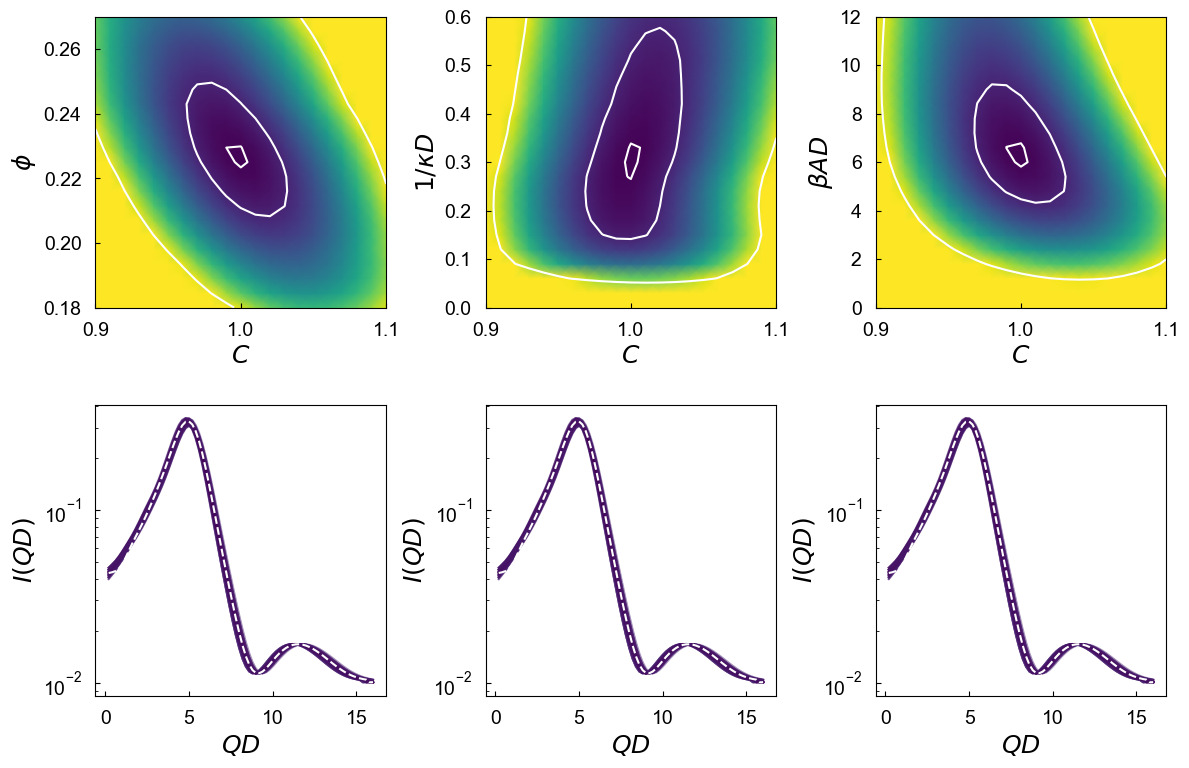

In [13]:
# parameter space grid
fig = plt.figure(figsize=(12,8))


# eta
ax = fig.add_subplot(2, 3, 1)

ax.pcolormesh(y_eta, x_eta, loss_grid_eta, vmin=0, vmax=1e-3, shading='gouraud')
ax.contour(y_eta, x_eta, loss_grid_eta, np.logspace(-5,-3,3), colors='w')
# ax.contour(x_eta, y_eta, loss_grid_eta, [1e-4], colors='w', linewidths=2)

ax.set_ylabel(r'$\phi$',fontsize=18)
ax.set_xlabel(r'$C$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=14, pad=10)
ax.set_box_aspect(1)

# kappa
ax = fig.add_subplot(2, 3, 2)

ax.pcolormesh(y_kappa, x_kappa, loss_grid_kappa, vmin=0, vmax=1e-3, shading='gouraud')
ax.contour(y_kappa, x_kappa, loss_grid_kappa, np.logspace(-5,-3,3), colors='w')
# ax.contour(x_kappa, y_kappa, loss_grid_kappa, [1e-4], colors='w', linewidths=2)

ax.set_ylabel(r'$1/\kappa D$',fontsize=18)
ax.set_xlabel(r'$C$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=14, pad=10)
ax.set_box_aspect(1)

# A
ax = fig.add_subplot(2, 3, 3)

ax.pcolormesh(y_A, x_A, loss_grid_A, vmin=0, vmax=1e-3, shading='gouraud')
ax.contour(y_A, x_A, loss_grid_A, np.logspace(-5,-3,3), colors='w')
# ax.contour(x_A, y_A, loss_grid_A, [1e-4], colors='w', linewidths=2)

ax.set_ylabel(r'$\beta AD$',fontsize=18)
ax.set_xlabel(r'$C$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=14, pad=10)
ax.set_box_aspect(1)

## IQ
ax = plt.subplot(2, 3, 4)
for i in range(len(IQ_list_eta)):
    if loss[i]>1e-4:
        continue
    r = (loss[i]-1e-5)/(1e-3-1e-5)
    c = cmap(r)
    ax.plot(q,IQ_list_eta[i],color=c[0:3], alpha=0.5)
    
ax.plot(q,IQ_exp_GT,'--',color='w')
ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=14, pad=10)
ax.set_box_aspect(1)
ax.set_yscale('log')

ax = plt.subplot(2, 3, 5)
for i in range(len(IQ_list_kappa)):
    if loss[i]>1e-4:
        continue
    r = (loss[i]-1e-5)/(1e-3-1e-5)
    c = cmap(r)
    ax.plot(q,IQ_list_eta[i],color=c[0:3], alpha=0.5)
    
ax.plot(q,IQ_exp_GT,'--',color='w')
ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=14, pad=10)
ax.set_box_aspect(1)
ax.set_yscale('log')

ax = plt.subplot(2, 3, 6)
for i in range(len(IQ_list_A)):
    if loss[i]>1e-4:
        continue
    r = (loss[i]-1e-5)/(1e-3-1e-5)
    c = cmap(r)
    ax.plot(q,IQ_list_eta[i],color=c[0:3], alpha=0.5)
    
ax.plot(q,IQ_exp_GT,'--',color='w')
ax.set_xlabel(r'$QD$',fontsize=18)
ax.set_ylabel(r'$I(QD)$',fontsize=18)
ax.tick_params(direction='in', axis='both', which='both', labelsize=14, pad=10)
ax.set_box_aspect(1)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [14]:
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(2, 1, 1)

# for i in range(len(IQ_list_eta)):
#     if loss[i]>1e-4:
#         continue
#     r = (loss[i]-1e-5)/(1e-3-1e-5)
#     c = cmap(r)
#     ax.plot(q,IQ_list_eta[i],color=c[0:3], alpha=0.5)
    
# ax.plot(q,IQ_exp_GT,'--',color='w')

# # ax2 = plt.subplot(2, 1, 2)
# # for i in range(len(IQ_list)):
# #     if loss[i]>1e-4:
# #         continue
# #     r = (loss[i]-1e-5)/(1e-3-1e-5)
# #     c = cmap(r)
# #     ax2.plot(IQ_list[i]-IQ_exp_GT,color=c[0:3], alpha=0.1)
# # ax2.set_ylim(-0.1,0.1)

# # ax.tick_params(direction='in', axis='both', which='both', labelsize=16)
# # ax2.tick_params(direction='in', axis='both', which='both', labelsize=16)

# plt.show()